# <p style="text-align: center;"> CS6476 | Computer Vision ps5 </p>
<p style="text-align: center;">Alexis Durocher - MSCS student at Georgia Tech</p>
<p style="text-align: center;">Spring 2018</p>


In [148]:
import cv2

from scipy import ndimage
from scipy import misc
import math as mt
import numpy as np
import math as mtugh
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from  scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler

<i> In this project, the aim is Finally, we  </i>

In [168]:
def compute_gradient(kernel, picture):
    height, width = picture.shape
    kl = len(kernel)
    ks = int((kl - 1)/2)
    gradient = np.zeros(picture.shape)
    
    for row in range(ks, height - ks):
        for col in range(ks, width - ks):
            grad = 0
            for ki in range(kl):
                for kj in range(kl):
                    # compute convolution
                    grad += grad + (picture[row-ks+ki][col-ks+kj] * kernel[ki][kj]) 
            gradient[row, col] = grad        
        
    return gradient

def image_pair(image1, image2):
    return np.concatenate([image1, image2], axis =1)

In [25]:
kernel_x = np.array([[-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]])

kernel_y = np.array([[-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]])

### 1. Laplacian/Gaussian pyramids

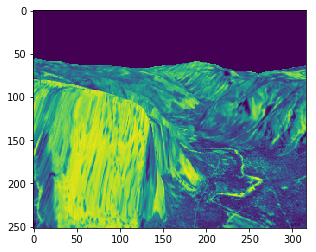

In [3]:
yos_1 = cv2.imread('./images/DataSeq1/yos_img_01.jpg', 0)
yos_2 = cv2.imread('./images/DataSeq1/yos_img_02.jpg', 0)
yos_3 = cv2.imread('./images/DataSeq1/yos_img_03.jpg', 0)
plt.imshow(yos_1)
plt.show()

#### 1.1  Reduce

In [18]:
def reduce(image, n_levels = 4):
    gaussian_pyramid = {}
    gaussian_pyramid[0] = image

    for level in range(0, n_levels-1):
        img_n = gaussian_pyramid[level]
        smoothed = cv2.GaussianBlur(img_n,(5,5),0)
        reduced = cv2.resize(smoothed, (0,0), fx = 0.5, fy = 0.5)
        gaussian_pyramid[level+1] = reduced
    return gaussian_pyramid

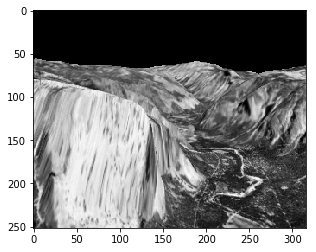

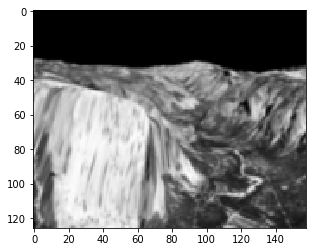

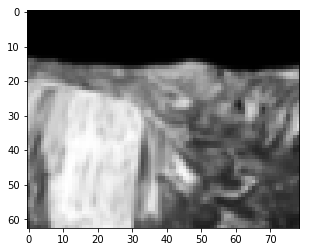

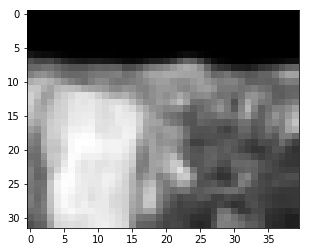

In [19]:
gaussian_pyramid = reduce(yos_1, 4)

for level, image in gaussian_pyramid.items():
    plt.imshow(image, cmap ='gray')
    plt.savefig('./output/PS5-1-1-'+str(level)+'.png')
    plt.show()

#### 1.2 Expand 

In [22]:
def expand(image, n_levels):
    gaussian_pyramid = reduce(image, n_levels)
    laplacian_pyramid = {}
    for key, image in gaussian_pyramid.items():
        if (key == n_levels -1):
            laplacian_pyramid[key] = image
        else:
            h, w = gaussian_pyramid[key].shape
            laplacian_pyramid[key] = gaussian_pyramid[key] - cv2.resize(
            gaussian_pyramid[int(key) + 1], (w,h))
    return laplacian_pyramid

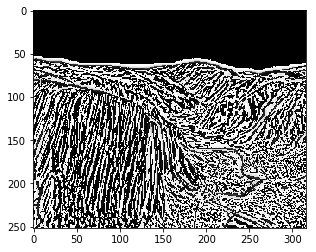

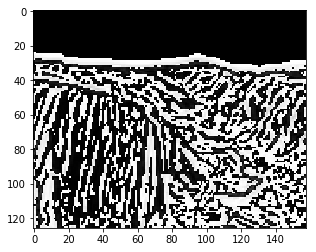

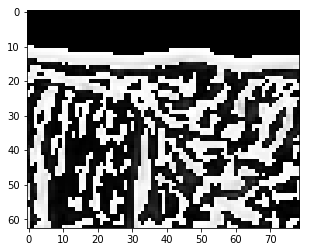

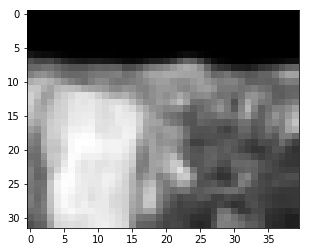

In [23]:
laplacian_pyramid = expand(yos_1, 4)
for level, image in laplacian_pyramid.items():
    plt.imshow(image, cmap ='gray')
    plt.savefig('./output/PS5-1-2-'+str(level)+'.png')
    plt.show()

#### 2. Lucas Kanade

In [247]:
shift0 = cv2.imread('./images/TestSeq/Shift0.png', 0)
shiftR2 = cv2.imread('./images/TestSeq/ShiftR2.png', 0)
shiftR5U5 = cv2.imread('./images/TestSeq/ShiftR5U5.png', 0)
shift0_smo = cv2.GaussianBlur(shift0, (5,5), sigmaX = 5, sigmaY =5)
shiftR2_smo = cv2.GaussianBlur(shiftR2, (5,5), sigmaX = 5, sigmaY =5)
shiftR5U5_smo = cv2.GaussianBlur(shiftR5U5, (5,5), sigmaX = 5, sigmaY =5)

In [219]:
def compute_sum(image, ks, r, c):
    sum_tot = image[r-ks:r+ks+1, c-ks:c+ks+1].sum()
    return sum_tot

def solve_lk(mat_grads, mat_t):
    a, b, c, d = mat_grads[0,0], mat_grads[0,1], mat_grads[1,0], mat_grads[1,1]
    e, f = mat_t[0], mat_t[1]
    v = (-f + (c*e)/a) / ( d - (b*c)/a)
    u = (-e - b*v) / a
    return u, v


def solve_lk_mat(mat_grads, mat_t):
    vec = np.dot(np.linalg.inv(mat_grads), - mat_t)
    return vec[0], vec[1]

In [267]:
def compute_lk(image1, image2, window_size):
    ks = int((window_size-1)/2)
    Ix = compute_gradient(kernel_x, image1)
    Iy = compute_gradient(kernel_y, image1)
    It = image2 - image1   
    image_u, image_v = np.zeros(image1.shape), np.zeros(image1.shape)
    height, width = image1.shape
    for r in range(ks, height-ks):
        for c in range(ks, width-ks):
            el1 = compute_sum(Ix*Ix, ks, r, c)
            el2 = compute_sum(Iy*Iy, ks, r, c)
            el3 = compute_sum(Ix*Iy, ks, r, c)
            el4 = compute_sum(Ix*It, ks, r, c)
            el5 = compute_sum(Iy*It, ks, r, c)
            mat_grads = np.array([
                [el1, el3],
                [el3, el2]
            ])
            mat_t = np.array([el4, el5])
            u, v = solve_lk(mat_grads, mat_t)
            image_u[r, c] = u
            image_v[r, c] = v
    image_u = cv2.normalize(np.absolute(image_u), 0, 255, cv2.NORM_MINMAX)
    image_v = cv2.normalize(np.absolute(image_v), 0, 255, cv2.NORM_MINMAX)
    return image_u, image_v

#### Lukas Kanade : shift 2 right 

In [268]:
shiftR2_u, shiftR2_v = compute_lk(shift0_smo, shiftR2_smo, 11)

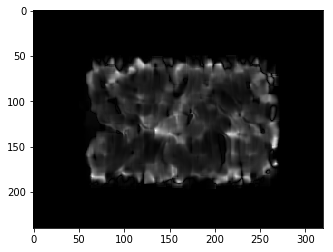

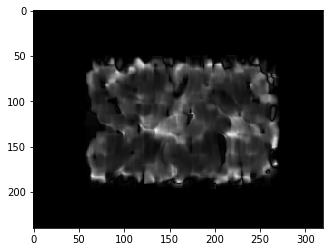

In [269]:
plt.imshow(shiftR2_u, cmap= 'gray')
plt.show()
plt.imshow(shiftR2_v, cmap ='gray')
plt.show()

#### Lukas Kanade : shift 2 right / 5 up

In [265]:
shiftR5U5_U, shiftR5U5_V = compute_lk(shift0_smo,shiftR5U5_smo , 11)

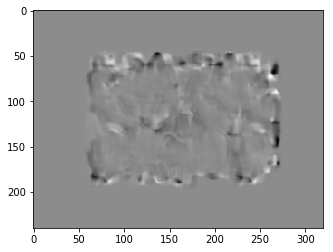

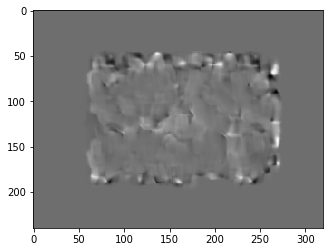

In [266]:
plt.imshow(shiftR5U5_U, cmap= 'gray')
plt.show()
plt.imshow(shiftR5U5_V, cmap ='gray')
plt.show()